In [6]:
import xarray as xr
import numpy as np
import os

# 1. 路径设置 (保持你之前的路径)
file_path = r'../data_generators/dataset_yrd.nc'

# 2. 读取数据
ds = xr.open_dataset(file_path)

# --- A. 基础信息输出 ---
print("=== 维度信息 ===")
print(f"时间维度 (time): {ds.sizes['time']}")
print(f"站点维度 (station): {ds.sizes['station']}")

# 获取所有变量名 (PM2.5, O3, t2m, etc.)
var_names = list(ds.data_vars)
print(f"\n包含的变量: {var_names}")


# 如果你想把所有变量堆叠成一个大数组用于训练模型
all_data_list = []
for var in var_names:
    all_data_list.append(ds[var].values)

# stack 堆叠: axis=-1 表示在最后一个维度增加变量维
# 结果形状: (70128, 127, 10)
full_time_series_array = np.stack(all_data_list, axis=-1)

print(f"\n=== 最终合并的时间序列数组 ===")
print(f"Shape: {full_time_series_array.shape}")
print("含义: (时间步, 站点数, 特征变量数)")
print(f"其中特征顺序对应: {var_names}")

ds.close()

=== 维度信息 ===
时间维度 (time): 70128
站点维度 (station): 127

包含的变量: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']

=== 最终合并的时间序列数组 ===
Shape: (70128, 127, 10)
含义: (时间步, 站点数, 特征变量数)
其中特征顺序对应: ['PM2.5', 'O3', 't2m', 'd2m', 'sp', 'tp', 'blh', 'msdwswrf', 'u100', 'v100']


In [4]:
import pandas as pd
import plotly.express as px

df = pd.read_csv('../data_generators/stations_yrd.csv')
micro_name = list(df["station_id"])

In [5]:
import pandas as pd
import plotly.express as px

fig = px.scatter(
    df,
    x="lon",
    y="lat",
    text="station_id",
    hover_data=["station_name", "city"]
)
fig.update_traces(textposition='top center')
fig.show()

# 数据展示

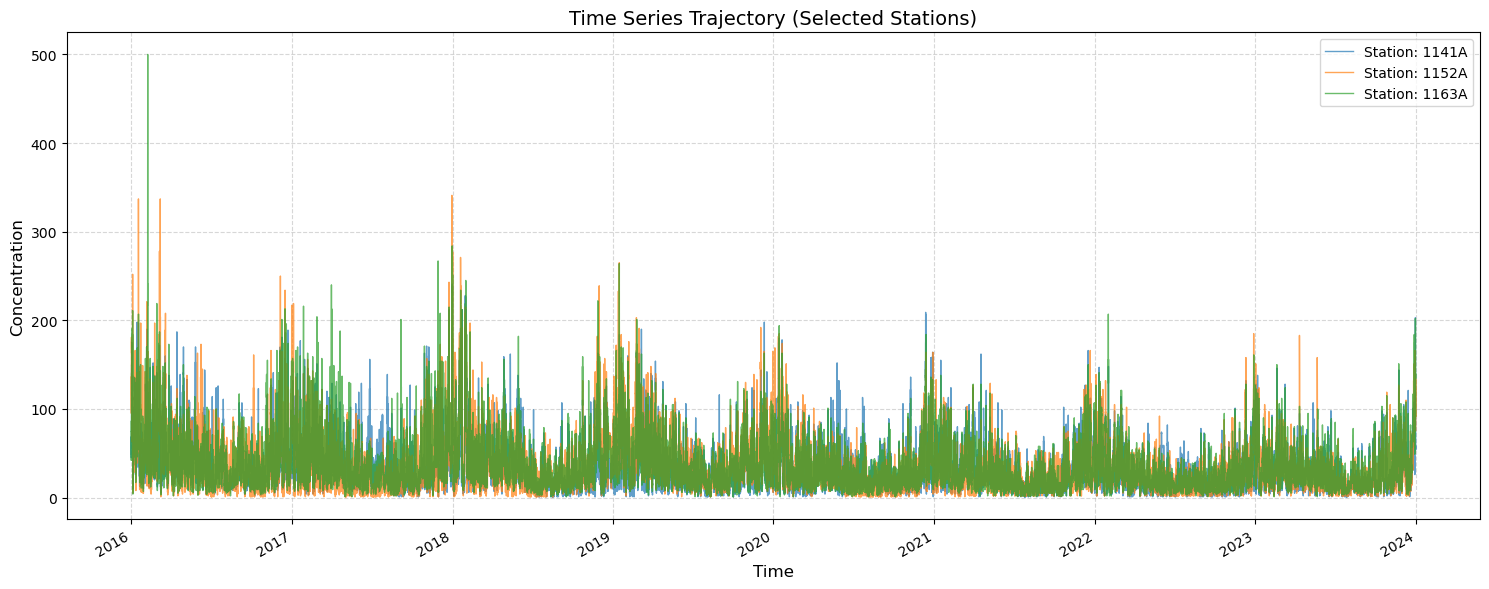

In [8]:
import matplotlib.pyplot as plt

num_stations_to_plot = 3
pm25 = ds['PM2.5']
o3 = ds['O3']
times = ds['time'].values
stations = ds['station'].values
# 方式 A: 随机选择站点
# selected_indices = np.random.choice(len(stations), num_stations_to_plot, replace=False)

# 方式 B: 手动指定前几个站点 (比较稳定，适合观察)
selected_indices = [0, 10, 20] # 比如第1个、第11个、第21个站点

# 创建画布
plt.figure(figsize=(15, 6))

# 循环绘制选定站点的曲线
for idx in selected_indices:
    station_name = stations[idx]
    # 提取该站点的 PM2.5 数据
    # .isel(station=idx) 按索引取
    station_data_o3 = o3.isel(station=idx).values
    station_data_pm25 = pm25.isel(station=idx).values
    
    plt.plot(times, station_data_pm25, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# 添加图表细节
plt.title('Time Series Trajectory (Selected Stations)', fontsize=14)
plt.ylabel('Concentration', fontsize=12)
plt.xlabel('Time', fontsize=12)
plt.legend(loc='upper right')
plt.grid(True, linestyle='--', alpha=0.5)

# 优化时间轴显示 (防止重叠)
plt.gcf().autofmt_xdate()

plt.tight_layout()
plt.show()

# 算法处理

In [9]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from scipy.integrate import odeint
import scipy
import seaborn as sns
import sklearn
import pysindy as ps 
from sklearn.linear_model import Lasso
from tools import get_positive_contributions, compute_entropy, print_equations
from data_func import plot_clustered_kuramoto, generate_kuramoto_cluster_data_sin_cos
import warnings
from sklearn.exceptions import ConvergenceWarning

# 仅忽略收敛警告
warnings.filterwarnings("ignore", category=ConvergenceWarning)

In [10]:
x_data = pm25.values
x_data.shape

(70128, 127)

In [11]:
# 候选的观测函数
ide = ps.IdentityLibrary()
fourier = ps.FourierLibrary(n_frequencies=1)
ode_lib = ps.PolynomialLibrary(degree=2,include_bias=False)
library_functions = [
    lambda x: x,
    lambda x: np.sin(x),
    lambda x: np.cos(x),
]
custom_library = ps.CustomLibrary(library_functions=library_functions)

# 选定观测函数
library = ide #+ fourier #custom_library

# 进行lift
library.fit(x_data)
x_data_lift = library.transform(x_data)
names = library.get_feature_names(micro_name)

# 单时间序列
print(x_data_lift.shape)
# 多时间序列
#print(x_data_lift[0].shape)
# 检查观测函数变量名
print(names)

(70128, 127)
['1141A', '1142A', '1143A', '1144A', '1145A', '1147A', '1148A', '1149A', '1150A', '1151A', '1152A', '1153A', '1154A', '1155A', '1156A', '1157A', '1158A', '1159A', '1160A', '1162A', '1163A', '1164A', '1165A', '1166A', '1167A', '1168A', '1169A', '1170A', '1171A', '1172A', '1186A', '1188A', '1189A', '1190A', '1191A', '1192A', '1193A', '1194A', '1195A', '1196A', '1200A', '1201A', '1203A', '1204A', '1205A', '1206A', '1207A', '1209A', '1223A', '1224A', '1226A', '1227A', '1228A', '1230A', '1231A', '1232A', '1233A', '1234A', '1235A', '1236A', '1239A', '1240A', '1241A', '1247A', '1250A', '1252A', '1253A', '1255A', '1256A', '1257A', '1258A', '1259A', '1260A', '2869A', '2870A', '2871A', '2872A', '2873A', '2907A', '2921A', '2997A', '3002A', '3003A', '3010A', '3164A', '3195A', '3265A', '3266A', '3268A', '3269A', '3270A', '3271A', '3272A', '3273A', '3274A', '3287A', '3289A', '3290A', '3291A', '3294A', '3295A', '3407A', '3408A', '3409A', '3410A', '3411A', '3422A', '3423A', '3424A', '3425

In [12]:
# 离散的迭代方程 or 连续的微分方程
discrete_time=True
if discrete_time:
    dt = 1
else:
    dt = 1#np.array(range(x_data_lift.shape[0]))

# 候选拟合器
sr3_optimizer = ps.SR3(reg_weight_lam=0.001, regularizer="l2")
lasso_optimizer = Lasso(alpha=0.004, max_iter=1000, fit_intercept=True)
stlsq_optimizer = ps.STLSQ(threshold=0.01, alpha=0.9, verbose=False)

optimizer = sr3_optimizer

# 进行拟合
model = ps.SINDy(feature_library=ide, optimizer=optimizer, discrete_time=discrete_time)
model.fit(x_data_lift, t=dt, feature_names=names)
model.print()

(1141A)[k+1] = 0.531 1141A[k] + -0.015 1142A[k] + 0.065 1143A[k] + -0.023 1144A[k] + 0.065 1145A[k] + 0.053 1147A[k] + 0.021 1148A[k] + -0.015 1149A[k] + 0.013 1150A[k] + 0.004 1151A[k] + -0.011 1152A[k] + 0.017 1153A[k] + -0.012 1154A[k] + 0.018 1155A[k] + -0.004 1156A[k] + -0.010 1157A[k] + 0.005 1158A[k] + 0.006 1159A[k] + -0.020 1160A[k] + -0.017 1162A[k] + -0.018 1163A[k] + 0.009 1164A[k] + 0.008 1165A[k] + 0.023 1166A[k] + 0.013 1167A[k] + -0.012 1168A[k] + 0.039 1169A[k] + 0.006 1170A[k] + 0.026 1171A[k] + -0.012 1172A[k] + 0.011 1186A[k] + -0.011 1188A[k] + -0.010 1189A[k] + 0.027 1190A[k] + -0.016 1191A[k] + -0.007 1192A[k] + -0.018 1193A[k] + 0.006 1194A[k] + 0.015 1195A[k] + -0.002 1196A[k] + 0.020 1200A[k] + 0.015 1201A[k] + 0.008 1203A[k] + -0.002 1204A[k] + -0.002 1205A[k] + 0.008 1206A[k] + -0.015 1207A[k] + 0.006 1209A[k] + 0.008 1223A[k] + -0.007 1224A[k] + -0.006 1226A[k] + -0.011 1227A[k] + -0.013 1228A[k] + -0.005 1230A[k] + -0.006 1231A[k] + -0.002 1232A[k] + -0.01

In [13]:
model.score(x_data_lift, t=dt)

0.9438696131484698

In [14]:
step_pred = 5
t = range(step_pred)
# 单时间序列
init_data = x_data_lift[0,:]
# 多时间序列
#init_data = x_data_lift[0][0,:]

if discrete_time:
    X_data_predicted = model.simulate(init_data,step_pred)
else:
    X_data_predicted = model.simulate(init_data,t) 

X_data_predicted.shape

(5, 127)

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_27456/2308130201.py:8: UserWarning:

FigureCanvasAgg is non-interactive, and thus cannot be shown



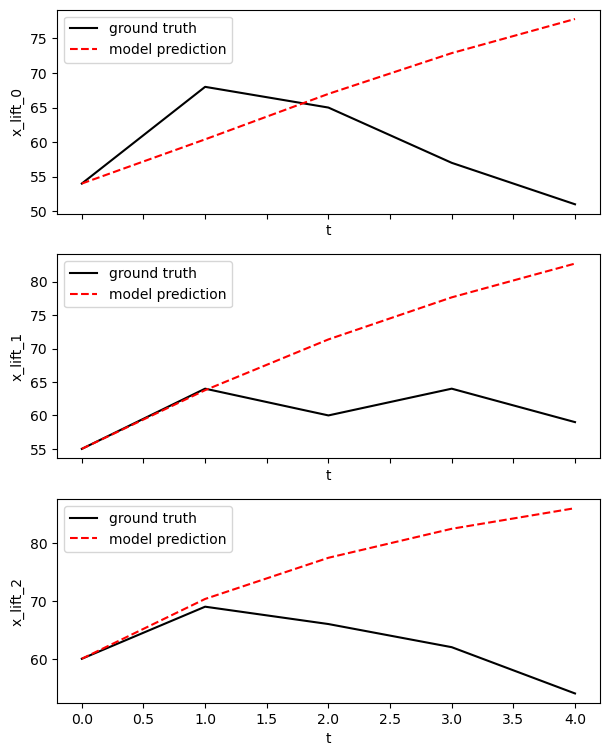

In [15]:
# 只看部分维度的多步预测
fig, axs = plt.subplots(3, 1, sharex=True, figsize=(7, 9))
for i in range(3):
    axs[i].plot(x_data_lift[:step_pred, i], "k", label="ground truth")
    axs[i].plot(X_data_predicted[:step_pred, i], "r--", label="model prediction")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=r"x_lift_{}".format(i))
fig.show()

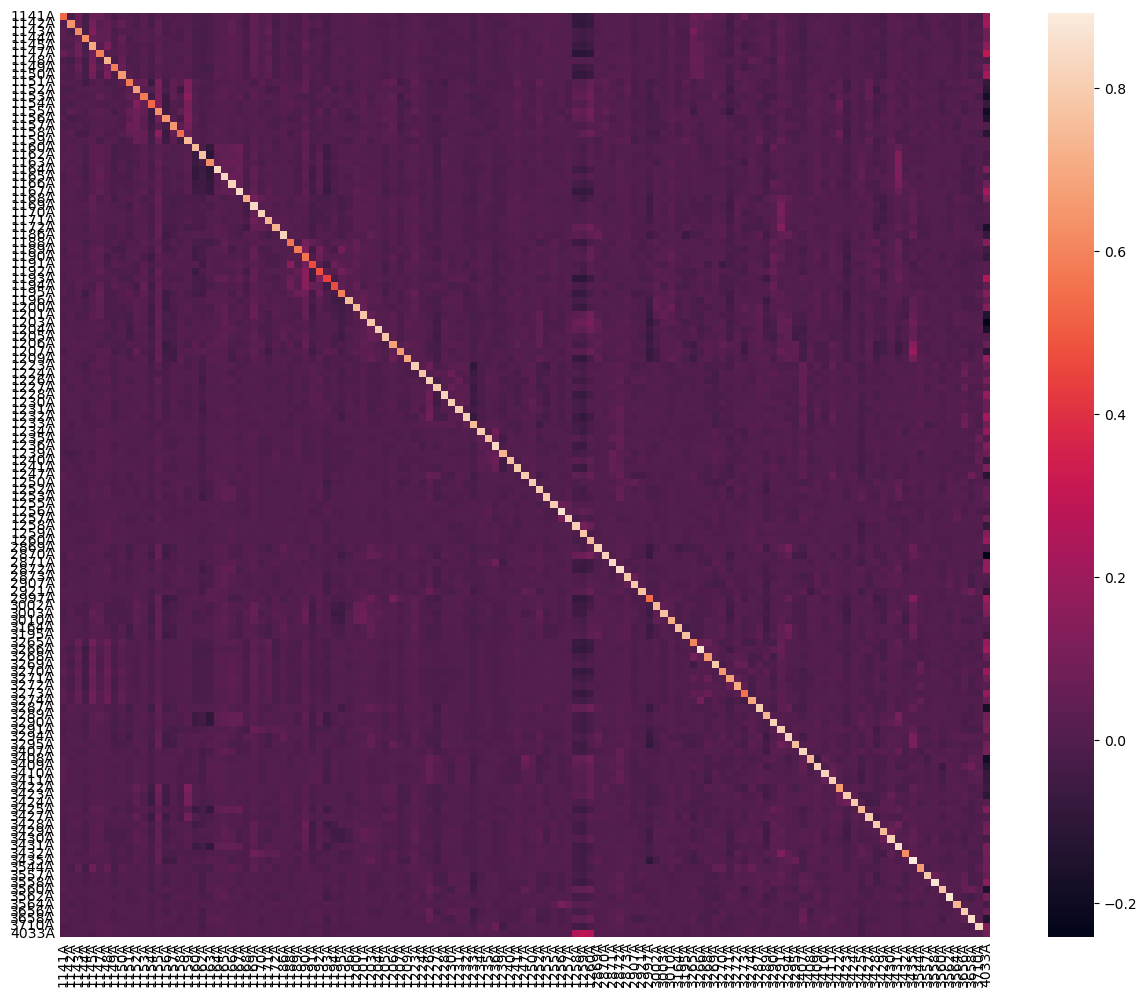

In [16]:
# 提取和处理系数矩阵
A = model.coefficients()
if discrete_time==False:
    A = scipy.linalg.expm(A)

# 只设置参数，不自动显示全部
plt.figure(figsize=(15, 12)) # 把画布搞大一点
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(A, xticklabels=names, yticklabels=names)
# 旋转横轴标签，避免重叠
plt.xticks(rotation=90)  # 旋转90度
plt.yticks(rotation=0)   # 纵轴保持水平
plt.show()

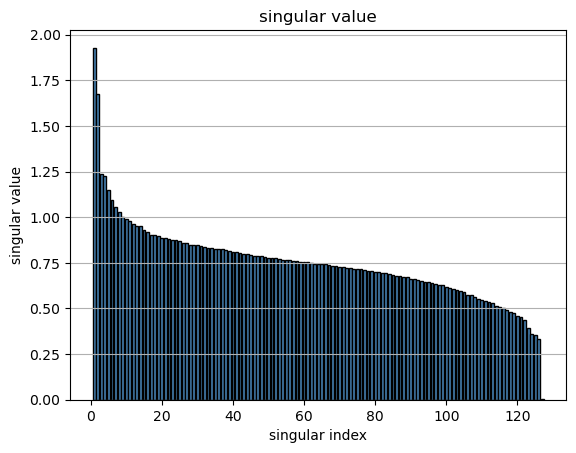

In [17]:
U,S,V = np.linalg.svd(A)
plt.figure()
plt.bar(np.arange(1, len(S)+1), S, color='steelblue', edgecolor='k')
plt.grid(True, axis='y')         
plt.xlabel('singular index')
plt.ylabel('singular value')
plt.title('singular value')
plt.show()

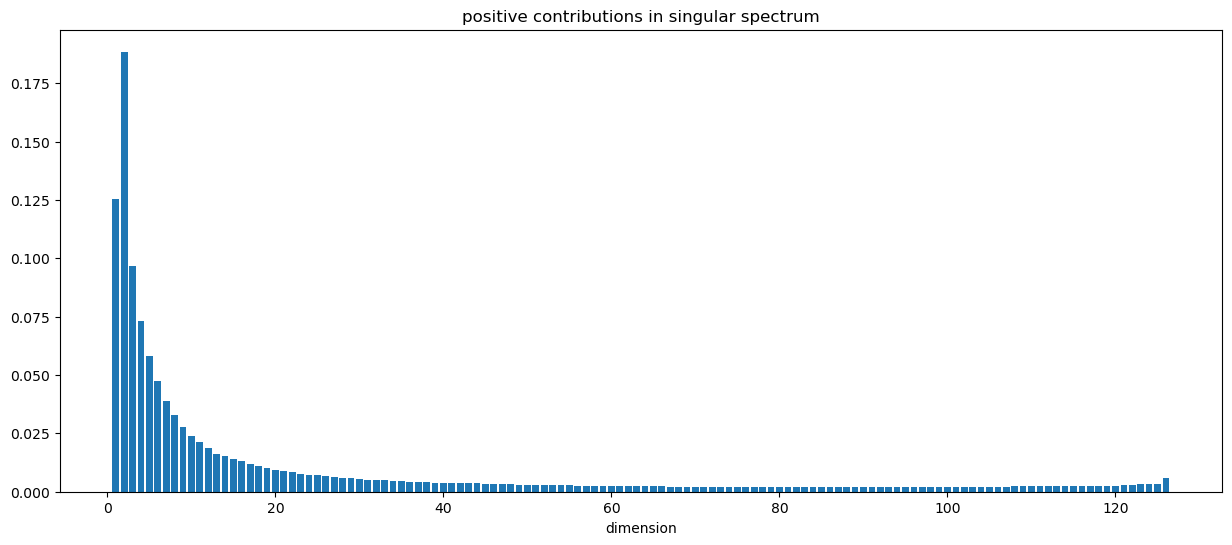

In [18]:
diff = get_positive_contributions(S)
#diff = diff[:50]
plt.figure(figsize=(15, 6))
plt.bar(range(1,len(diff)+1), diff) 
plt.xlabel('dimension')
plt.title('positive contributions in singular spectrum')
plt.show()

In [19]:
rank = 2
S_macro = S[:rank]
delt_gamma = sum(S_macro) / rank - sum(S) / len(S)
print(delt_gamma)

1.0540226325789428


In [20]:
print(compute_entropy(diff))

5.346012354534826


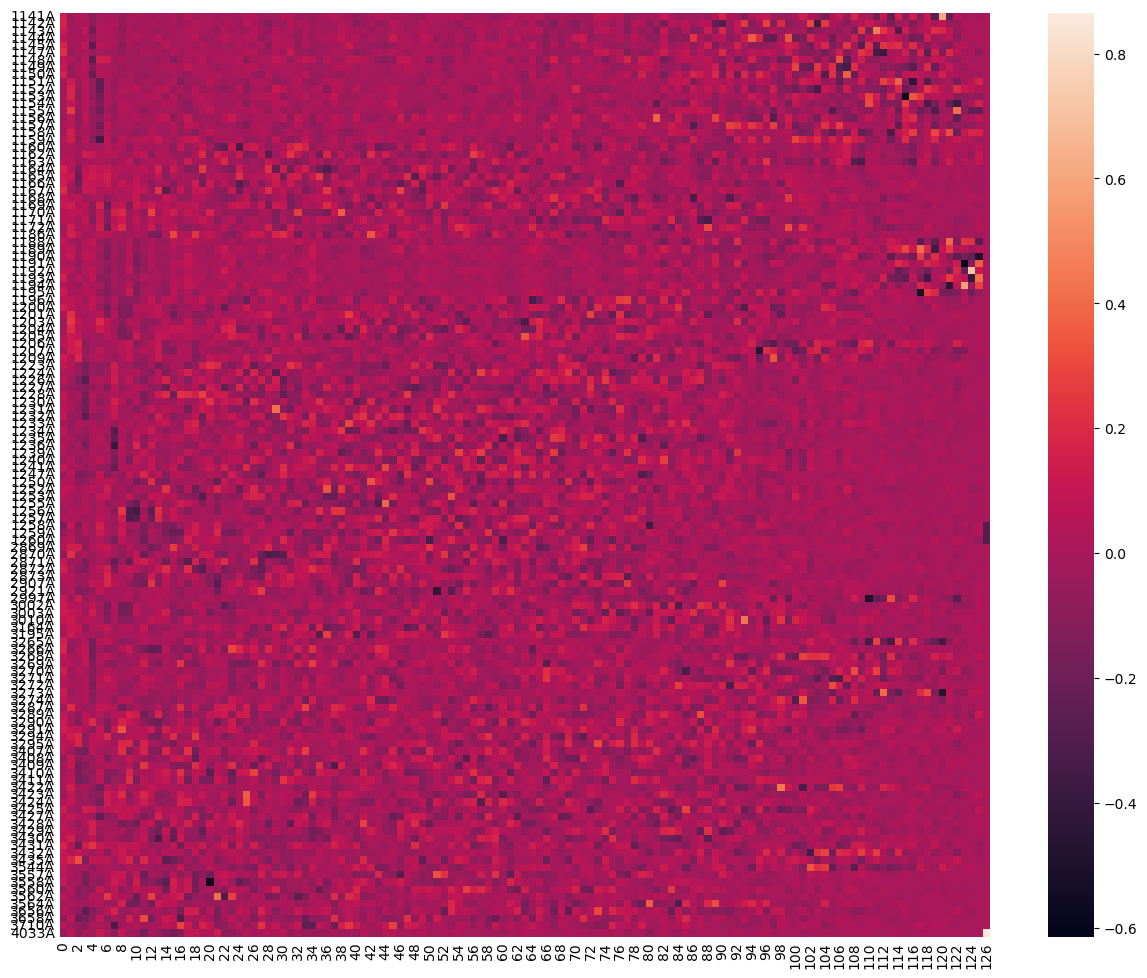

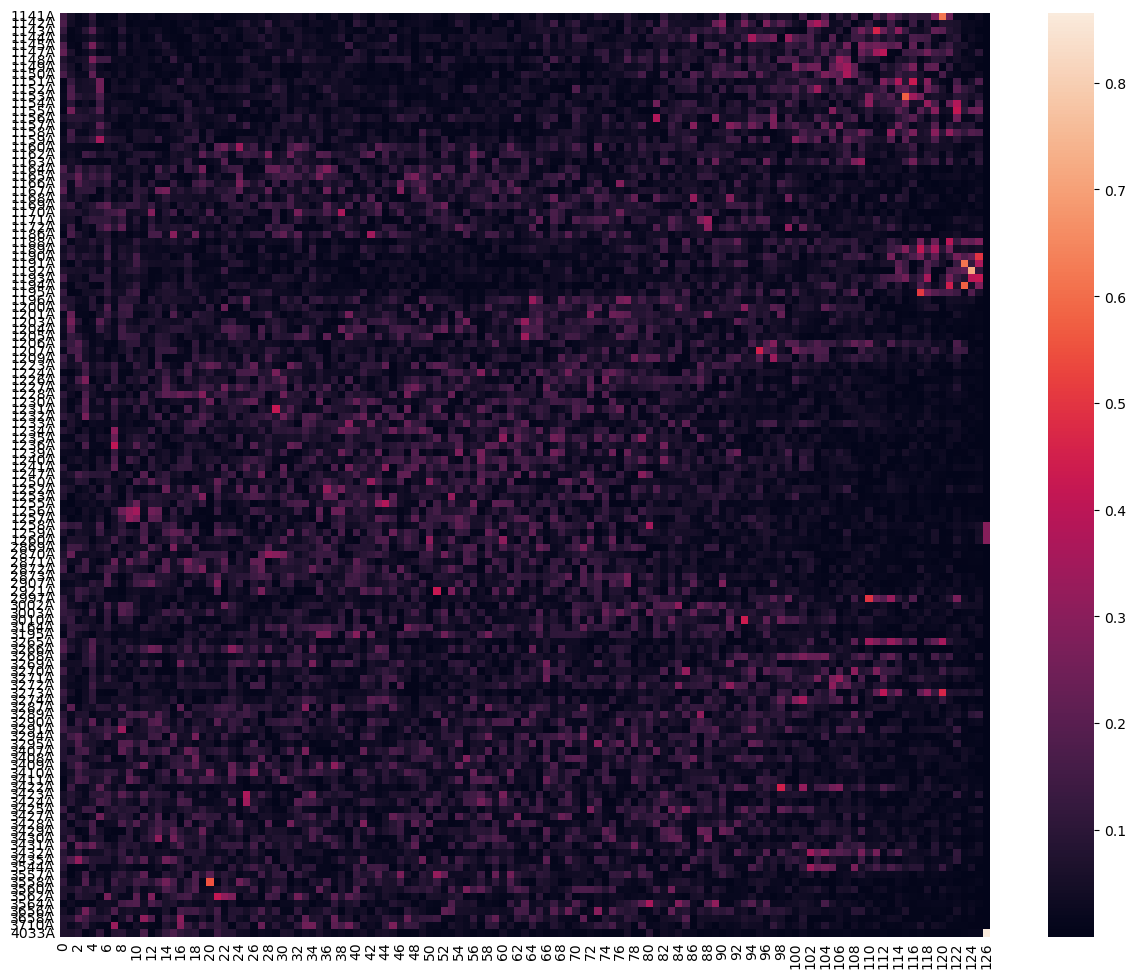

In [21]:
U_abs = np.abs(U)

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(U_abs, yticklabels=names)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show() 

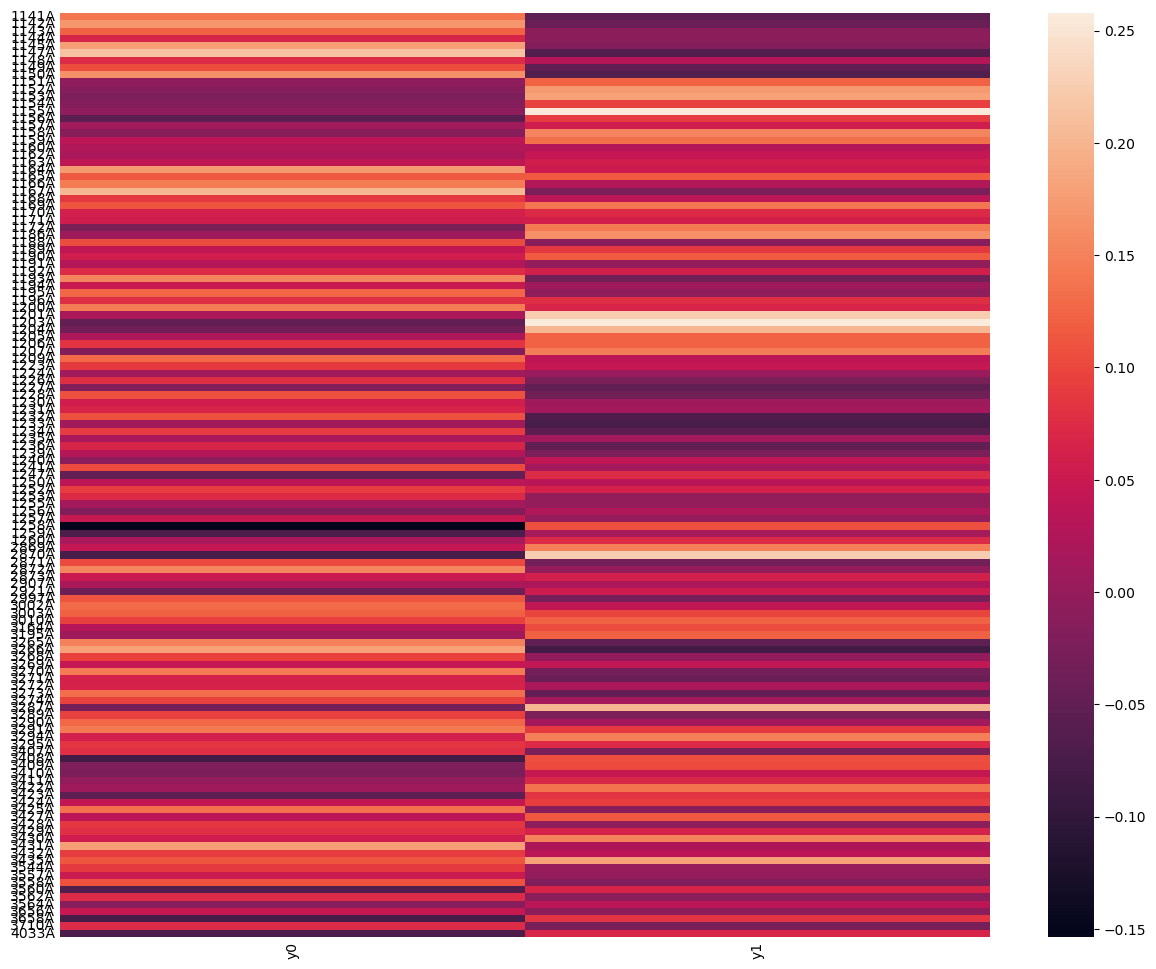

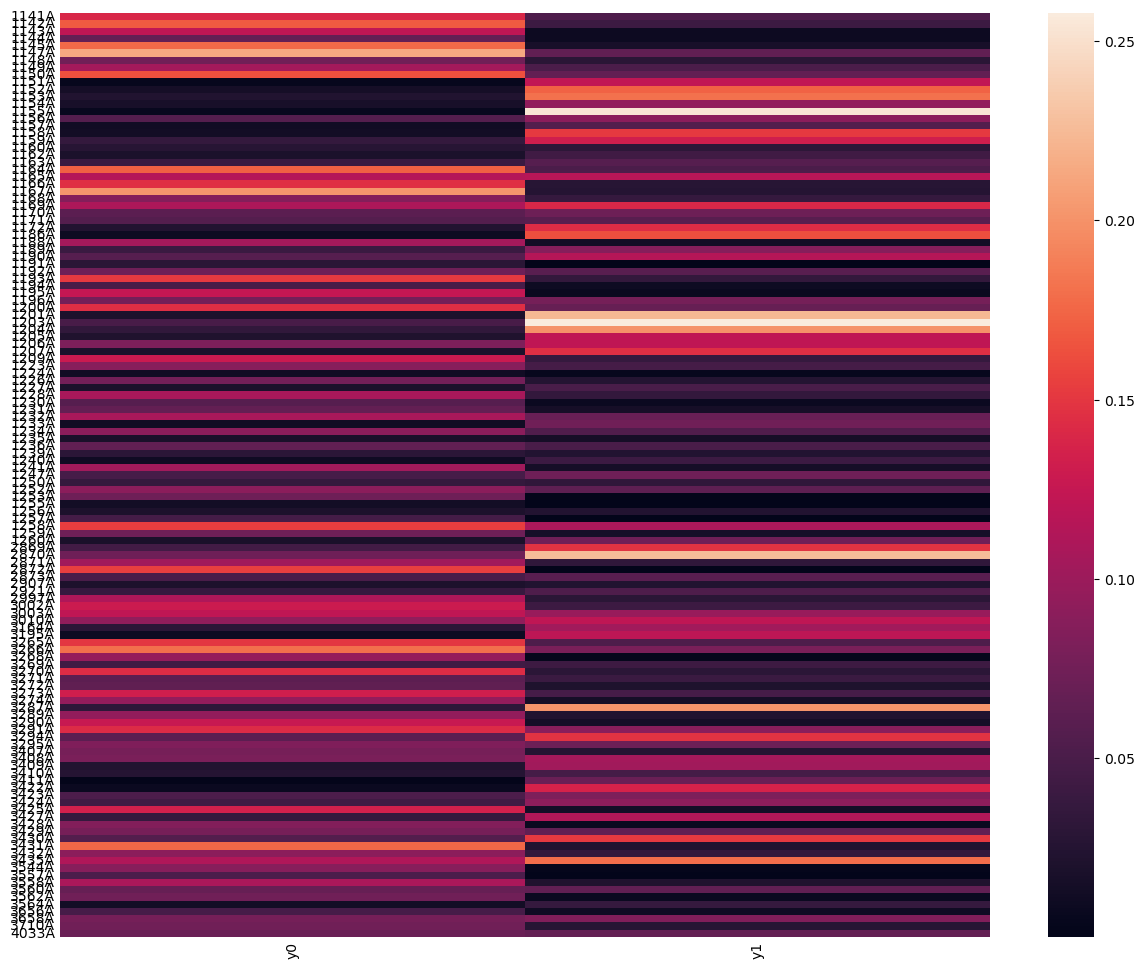

In [22]:
macro_name = [f'y{i}' for i in range(rank)]
coarse_grain_coff = U[:,:rank]

plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(coarse_grain_coff, yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()


plt.figure(figsize=(15, 12)) 
plt.tick_params(axis='both', which='both', length=0)
_ = sns.heatmap(np.abs(coarse_grain_coff), yticklabels=names, xticklabels=macro_name)
plt.xticks(rotation=90)  
plt.yticks(rotation=0)   
plt.show()

In [24]:
import pandas as pd
import plotly.express as px
import plotly.graph_objects as go
import numpy as np

# 假设 df 是已经加载好的站点数据 DataFrame
# df = pd.read_csv('stations_yrd.csv') 

# 假设 coarse_grain_coff 是一个 numpy 数组，行数与 df 相同
# 示例：创建一个随机数组作为演示
# num_stations = len(df)
# num_columns = 3
# coarse_grain_coff = np.random.rand(num_stations, num_columns) 

#coarse_grain_coff = U[:,:rank]
coarse_grain_coff = U_abs[:,:rank]

if isinstance(coarse_grain_coff, np.ndarray):
    coff_df = pd.DataFrame(coarse_grain_coff)
else:
    coff_df = coarse_grain_coff.reset_index(drop=True)

# 2. 遍历每一列进行绘图
for col_idx in coff_df.columns:
    # 将当前列的数据合并到原始 df 中，命名为一个临时列名，例如 'value_to_plot'
    df_plot = df.copy()
    df_plot['value_to_plot'] = coff_df[col_idx].values
    
    # 绘制图形
    fig = px.scatter(
        df_plot,
        x="lon",
        y="lat",
        text="station_id",
        color="value_to_plot",  # 核心修改：颜色映射到当前列的数值
        hover_data=["station_name", "city"],
        color_continuous_scale='Viridis', # 设置颜色条，可选 'Plasma', 'Inferno', 'Turbo' 等
        title=f"y{col_idx}"
    )
    
    # 调整标注位置和点的大小
    fig.update_traces(
        textposition='top center',
        marker=dict(size=10, opacity=0.8) # 稍微调大点的大小以看清颜色
    )
    
    # 优化布局：保持经纬度比例，以免地图变形
    fig.update_layout(
        yaxis_scaleanchor="x", 
        yaxis_scaleratio=1,
        height=600,
        width=800
    )
    
    fig.show()

In [43]:
print_equations(coarse_grain_coff, names, macro_name)

y0 = 0.0326 * x0 + 0.0636 * x1 + 0.0648 * x2 + 0.0538 * x3 + 0.1049 * x4 + 0.0692 * x5 + 0.0547 * x6 + 0.0347 * x7 + 0.0719 * x8 + 0.0888 * x9 + 0.1004 * x10 + 0.0977 * x11 + 0.1059 * x12 + 0.0997 * x13 + 0.0364 * x14 + 0.0861 * x15 + 0.0919 * x16 + 0.0992 * x17 + 0.0511 * x18 + 0.0798 * x19 + 0.0787 * x20 + 0.1002 * x21 + 0.0739 * x22 + 0.0507 * x23 + 0.0533 * x24 + 0.0971 * x25 + 0.0791 * x26 + 0.0601 * x27 + 0.0815 * x28 + 0.0784 * x29 + 0.0719 * x30 + 0.0904 * x31 + 0.1015 * x32 + 0.1230 * x33 + 0.0904 * x34 + 0.1032 * x35 + 0.1554 * x36 + 0.1151 * x37 + 0.0936 * x38 + 0.0776 * x39 + 0.0928 * x40 + 0.1551 * x41 + 0.0758 * x42 + 0.0579 * x43 + 0.0576 * x44 + 0.0938 * x45 + 0.0727 * x46 + 0.1202 * x47 + 0.0648 * x48 + 0.0751 * x49 + 0.1338 * x50 + 0.1515 * x51 + 0.0467 * x52 + 0.1171 * x53 + 0.0535 * x54 + 0.1168 * x55 + 0.0917 * x56 + 0.0732 * x57 + 0.0794 * x58 + 0.0939 * x59 + 0.0570 * x60 + 0.0591 * x61 + 0.0717 * x62 + 0.0715 * x63 + 0.1627 * x64 + 0.0656 * x65 + 0.1202 * x66 + 

/var/folders/mw/53dhwskj4zq47dtls4lhht4m0000gn/T/ipykernel_15513/580934310.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


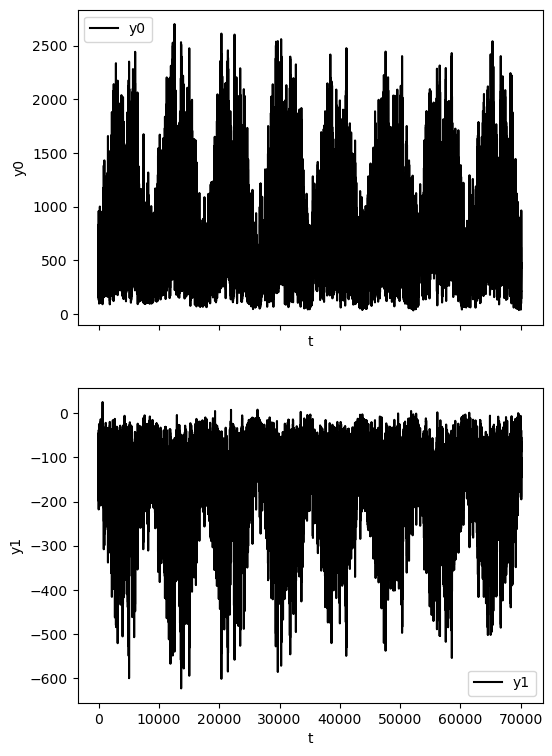

In [44]:
macro_data = x_data_lift @ coarse_grain_coff
macro_dim = macro_data.shape[1]

fig, axs = plt.subplots(macro_dim, 1, sharex=True, figsize=(int(3*macro_dim), 9))
for i in range(macro_dim):
    axs[i].plot(macro_data[:, i], "k", label=f"y{i}")
    axs[i].legend()
    axs[i].set(xlabel="t", ylabel=f"y{i}")
fig.show()

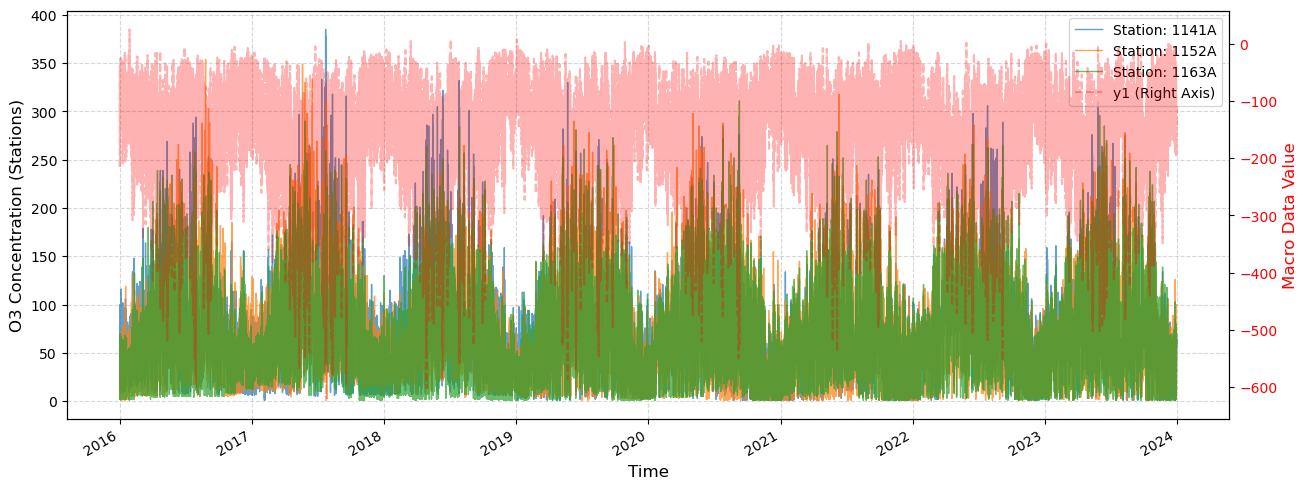

In [47]:
import matplotlib.pyplot as plt

# 1. 使用 subplots 创建画布和第一个坐标轴对象 (ax1)
fig, ax1 = plt.subplots(figsize=(15, 6))

# -------------------------------------------------
# 左侧 Y 轴 (ax1)：绘制各个站点的曲线
# -------------------------------------------------
ax1.set_xlabel('Time', fontsize=12)
ax1.set_ylabel('O3 Concentration (Stations)', fontsize=12) # 左轴标签
ax1.grid(True, linestyle='--', alpha=0.5)

# 循环绘制选定站点的曲线 (画在 ax1 上)
for idx in selected_indices:
    station_name = stations[idx]
    # 提取数据 (保持原有逻辑)
    station_data = o3.isel(station=idx).values
    
    # 注意这里使用的是 ax1.plot
    ax1.plot(times, station_data, label=f'Station: {station_name}', alpha=0.7, linewidth=1)

# -------------------------------------------------
# 右侧 Y 轴 (ax2)：绘制最后一条宏观数据线
# -------------------------------------------------
ax2 = ax1.twinx()  # 关键步骤：创建共享X轴的第二个Y轴
ax2.set_ylabel('Macro Data Value', color='red', fontsize=12) # 右轴标签，设为红色以区分
ax2.tick_params(axis='y', labelcolor='red') # 设置右轴刻度颜色为红色

# 绘制最后一条线 (画在 ax2 上)
# 注意这里使用的是 ax2.plot
ax2.plot(times, macro_data[:, 1], color="red", linestyle='--', alpha=0.3, label=f"y{1} (Right Axis)")

# -------------------------------------------------
# 合并图例 (让两个轴的图例显示在一起)
# -------------------------------------------------
# 分别获取两个轴的图例句柄和标签
lines_1, labels_1 = ax1.get_legend_handles_labels()
lines_2, labels_2 = ax2.get_legend_handles_labels()
# 合并并显示
ax1.legend(lines_1 + lines_2, labels_1 + labels_2, loc='upper right')

# 优化时间轴显示
fig.autofmt_xdate()

plt.show()